In [1]:
import pandas as pd
import numpy as np
from ete3 import Tree
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
do_weighted = True

base_relevant_features = ["weighted NODF", # nestedness measures
                     "weighted connectance",
                     "modularity"] # modularity mesure, when there is only one compartment, the divsrity is nan
                     # "extinction.slope.HL", "robustness.HL", # robutness of pollinators, based on memmot 2004
                     # "extinction.slope.LL", "robustness.LL"] # robutness of plants,  based on memmot 2004
relevant_features = base_relevant_features+[f"null_standardized_{f}" for f in base_relevant_features]
relevant_metadata = ["number.of.species.HL", "number.of.species.LL"]
                          
network_polyploid_data_path = "../../../data/ploidy_classification/network_classification.csv"
taxonomic_data_path = "../../../data/features/taxonomic_features/net_to_pollinators_taxonomic_classification.csv"
networks_metadata_path = "../../../data/networks/all/networks_metadata.csv"

allmb_tree_path = "../../../data/trees/ALLMB.tre"
networks_dir = "../../../data/networks/all/"
species_features_paths = {"binary": "../../../data/features/network/binary/features_with_classification.csv",
                          "binarized_weighted": "../../../data/features/network/binarized_weighted/features_with_classification.csv",
                          "weighted": "../../../data/features/network/weighted/features_with_classification.csv"}

processed_data_path = f"../../../data/statistical_analysis/network_level/processed_features_with_ploidy_classification_on_{'un' if not do_weighted else ''}weighted_networks.csv"
processed_data_w_geo_path = f"../../../data/statistical_analysis/network_level/processed_features_with_ploidy_classification_and_geodata_on_{'un' if not do_weighted else ''}weighted_networks.csv"

bad_binary_networks = []# [46,48,50,51,54,55,56,57,61,62,63,64,66,70,71,72,73]
bad_weighted_networks = [] #[106,107,156,157,158,159]

In [102]:
network_to_highest_pollinator_rank = pd.read_csv(taxonomic_data_path)[["network_id", "network_type", "highest_rank_name"]]
network_to_highest_pollinator_rank.network_id = network_to_highest_pollinator_rank.network_id.astype(int)

In [103]:
classification = pd.read_csv(network_polyploid_data_path)
classification = classification[[c for c in classification.columns if not c.startswith("non_")]]
classification = classification.rename(columns={c: c.replace("conservative_", "") for c in classification.columns})
classification.head()

,Unnamed: 0,network_type,network_id,is_polyploid_poly_frac,is_polyploid_missing_frac,num_plants,num_resolved,num_classified,num_polyploids,num_diploids,path,num_pollinators
0,0,binary,0,0.0,0.75,8,2,2,0,2,../../data/networks/all/binary/0.csv,11
1,1,binary,1,0.0,1.00,51,0,0,0,0,../../data/networks/all/binary/1.csv,25
2,2,binary,2,0.0,1.00,15,0,0,0,0,../../data/networks/all/binary/2.csv,77
3,3,binary,3,0.0,1.00,68,0,0,0,0,../../data/networks/all/binary/3.csv,96
4,4,binary,4,0.0,1.00,14,0,0,0,0,../../data/networks/all/binary/4.csv,23


In [104]:
relevant_columns = ["network_id"] + relevant_features + relevant_metadata
weighted_data = pd.read_csv(species_features_paths["weighted"])[relevant_columns]
weighted_data = weighted_data.loc[~weighted_data.network_id.isin(bad_weighted_networks)]
weighted_data["network_type"] = "weighted"
weighted_data = weighted_data.merge(network_to_highest_pollinator_rank.query("network_type == 'weighted'")[["network_id", "highest_rank_name"]], on="network_id", how="left")
weighted_data = weighted_data.merge(classification.loc[classification.network_type=="weighted"].drop(["network_type"], axis=1), on="network_id", how="left")

binarized_weighted_data = pd.read_csv(species_features_paths["binarized_weighted"])[relevant_columns]
binarized_weighted_data = binarized_weighted_data.loc[~binarized_weighted_data.network_id.isin(bad_weighted_networks)]
binarized_weighted_data["network_type"] = "binarized_weighted"
binarized_weighted_data = binarized_weighted_data.merge(network_to_highest_pollinator_rank.query("network_type == 'weighted'")[["network_id", "highest_rank_name"]], on="network_id", how="left")
binarized_weighted_data = binarized_weighted_data.merge(classification.loc[classification.network_type=="weighted"].drop(["network_type"], axis=1), on="network_id", how="left")

binary_data = pd.read_csv(species_features_paths["binary"])[relevant_columns]
binary_data["network_type"] = "binary"  
binary_data = binary_data.loc[~binary_data.network_id.isin(bad_binary_networks)]
binary_data = binary_data.merge(network_to_highest_pollinator_rank.query("network_type == 'binary'")[["network_id", "highest_rank_name"]], on="network_id", how="left")
binary_data = binary_data.merge(classification.loc[classification.network_type=="binary"].drop(["network_type"], axis=1), on="network_id", how="left")

features = pd.concat([weighted_data,binarized_weighted_data,binary_data]).rename(columns={"number.of.species.HL": "num_network_pollinators",
                                                                                          "number.of.species.LL": "num_network_plants"})

In [105]:
features = features.drop_duplicates(["network_id", "network_type"])

In [106]:
features.groupby("network_type")["network_id"].count()

network_type
binarized_weighted    534
binary                177
weighted              531
Name: network_id, dtype: int64

In [107]:
features = features[[c for c in features.columns if not "Unnamed" in c]]

In [108]:
features.notna().sum() / features.shape[0]

network_id                                1.000000
weighted NODF                             1.000000
weighted connectance                      1.000000
modularity                                0.999195
null_standardized_weighted NODF           1.000000
null_standardized_weighted connectance    1.000000
null_standardized_modularity              0.999195
num_network_pollinators                   1.000000
num_network_plants                        1.000000
network_type                              1.000000
highest_rank_name                         0.943639
is_polyploid_poly_frac                    1.000000
is_polyploid_missing_frac                 1.000000
num_plants                                1.000000
num_resolved                              1.000000
num_classified                            1.000000
num_polyploids                            1.000000
num_diploids                              1.000000
path                                      1.000000
num_pollinators                

In [109]:
features = features.dropna(subset=["is_polyploid_poly_frac"])

In [110]:
clean_features = features #.loc[features.is_polyploid_missing_frac <= missing_data_threshold]

In [111]:
if do_weighted:
    clean_features = clean_features.loc[clean_features.network_type == "weighted"]
else:
    clean_features = clean_features.loc[clean_features.network_type != "weighted"]

In [112]:
print(f"# networks = {clean_features.shape[0]:,}")

# networks = 531


In [113]:
clean_features.notna().sum() / clean_features.shape[0]

network_id                                1.00000
weighted NODF                             1.00000
weighted connectance                      1.00000
modularity                                1.00000
null_standardized_weighted NODF           1.00000
null_standardized_weighted connectance    1.00000
null_standardized_modularity              1.00000
num_network_pollinators                   1.00000
num_network_plants                        1.00000
network_type                              1.00000
highest_rank_name                         0.93597
is_polyploid_poly_frac                    1.00000
is_polyploid_missing_frac                 1.00000
num_plants                                1.00000
num_resolved                              1.00000
num_classified                            1.00000
num_polyploids                            1.00000
num_diploids                              1.00000
path                                      1.00000
num_pollinators                           1.00000


# compute phylogenetic diversity on remaining networks

In [114]:
tree = Tree(allmb_tree_path, format=1)
for l in tree.get_leaves():
    l.name = l.name.replace("_", " ").lower()

In [115]:
def get_phylogenetic_diveristy(network_path: str) -> float:
    try:
        network = pd.read_csv(network_path)
        plants = network.Plant.str.lower().tolist()
        plants_in_tree = set(plants) & set(tree.get_leaf_names())
        network_tree = tree.copy()
        network_tree.prune(plants_in_tree)
        phylo_divesity = np.sum([n.dist for n in network_tree.traverse()]) / len(network_tree.get_leaves())
        return phylo_divesity
    except Exception as e:
        print(f"network_path={network_path}, error={e}")
        return np.nan

clean_features["pd"] = clean_features.parallel_apply(lambda rec: get_phylogenetic_diveristy(f"../../../data/networks/all/{rec.network_type}/{rec.network_id}.csv"), axis=1)

network_path=../../../data/networks/all/weighted/422.csv, error='Nodes are not connected!'
network_path=../../../data/networks/all/weighted/469.csv, error='Nodes are not connected!'
network_path=../../../data/networks/all/weighted/365.csv, error='Nodes are not connected!'
network_path=../../../data/networks/all/weighted/421.csv, error='Nodes are not connected!'
network_path=../../../data/networks/all/weighted/336.csv, error='Nodes are not connected!'
network_path=../../../data/networks/all/weighted/431.csv, error='Nodes are not connected!'
network_path=../../../data/networks/all/weighted/280.csv, error='Nodes are not connected!'
network_path=../../../data/networks/all/weighted/374.csv, error='Nodes are not connected!'
network_path=../../../data/networks/all/weighted/375.csv, error='Nodes are not connected!'
network_path=../../../data/networks/all/weighted/411.csv, error='Nodes are not connected!'
network_path=../../../data/networks/all/weighted/423.csv, error='Nodes are not connected!'

/tmp/ipykernel_1063/457000853.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_features["pd"] = clean_features.parallel_apply(lambda rec: get_phylogenetic_diveristy(f"../../../data/networks/all/{rec.network_type}/{rec.network_id}.csv"), axis=1)


In [116]:
clean_features.network_id = clean_features.network_id.astype(str) + "_" + clean_features.network_type

/tmp/ipykernel_1063/3719445971.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_features.network_id = clean_features.network_id.astype(str) + "_" + clean_features.network_type


<AxesSubplot: >

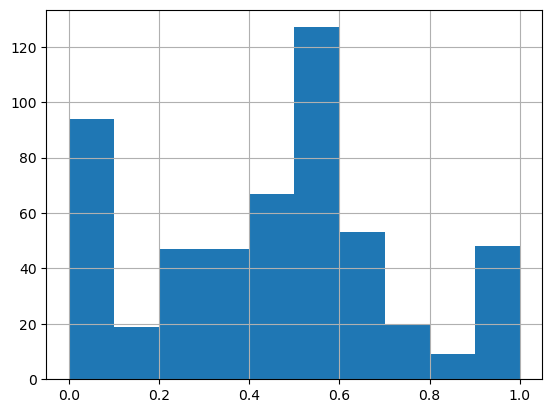

In [117]:
clean_features.is_polyploid_poly_frac.hist()

<AxesSubplot: >

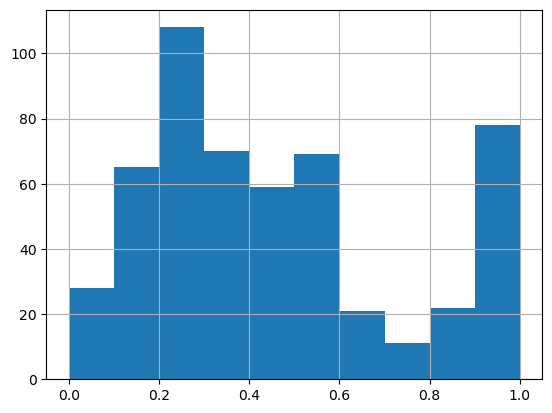

In [118]:
clean_features.is_polyploid_missing_frac.hist()

# apply box-cox transfomations on the variables to obtain a normal distribution

In [119]:
from scipy.stats import boxcox, shapiro

In [120]:
for f in base_relevant_features:
    data = clean_features[f"null_standardized_{f}"]
    pos_transfromed_data = data+abs(data.min())+0.0001
    res = boxcox(pos_transfromed_data)
    bc_transformed = res[0]
    clean_features[f"bc_transformed_{f}"] = list(bc_transformed)
    
    test1 = shapiro(clean_features[f"null_standardized_{f}"])
    test2 = shapiro(clean_features[f"bc_transformed_{f}"])
    print(f"\n\nfeature={f}\nshapiro result following delta transfromation = {test1}")
    print(f"\nshapiro result following box-cox+delta transfromation = {test2}")



feature=weighted NODF
shapiro result following delta transfromation = ShapiroResult(statistic=0.9455209970474243, pvalue=4.640059495485127e-13)

shapiro result following box-cox+delta transfromation = ShapiroResult(statistic=0.9587973952293396, pvalue=4.9804715906986985e-11)


feature=weighted connectance
shapiro result following delta transfromation = ShapiroResult(statistic=0.9916326999664307, pvalue=0.004331583622843027)

shapiro result following box-cox+delta transfromation = ShapiroResult(statistic=0.9913772344589233, pvalue=0.003492509014904499)


feature=modularity
shapiro result following delta transfromation = ShapiroResult(statistic=0.9881044626235962, pvalue=0.00025724369334056973)

shapiro result following box-cox+delta transfromation = ShapiroResult(statistic=0.9872144460678101, pvalue=0.0001326595520367846)


/tmp/ipykernel_1063/829928118.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_features[f"bc_transformed_{f}"] = list(bc_transformed)
/tmp/ipykernel_1063/829928118.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_features[f"bc_transformed_{f}"] = list(bc_transformed)
/tmp/ipykernel_1063/829928118.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

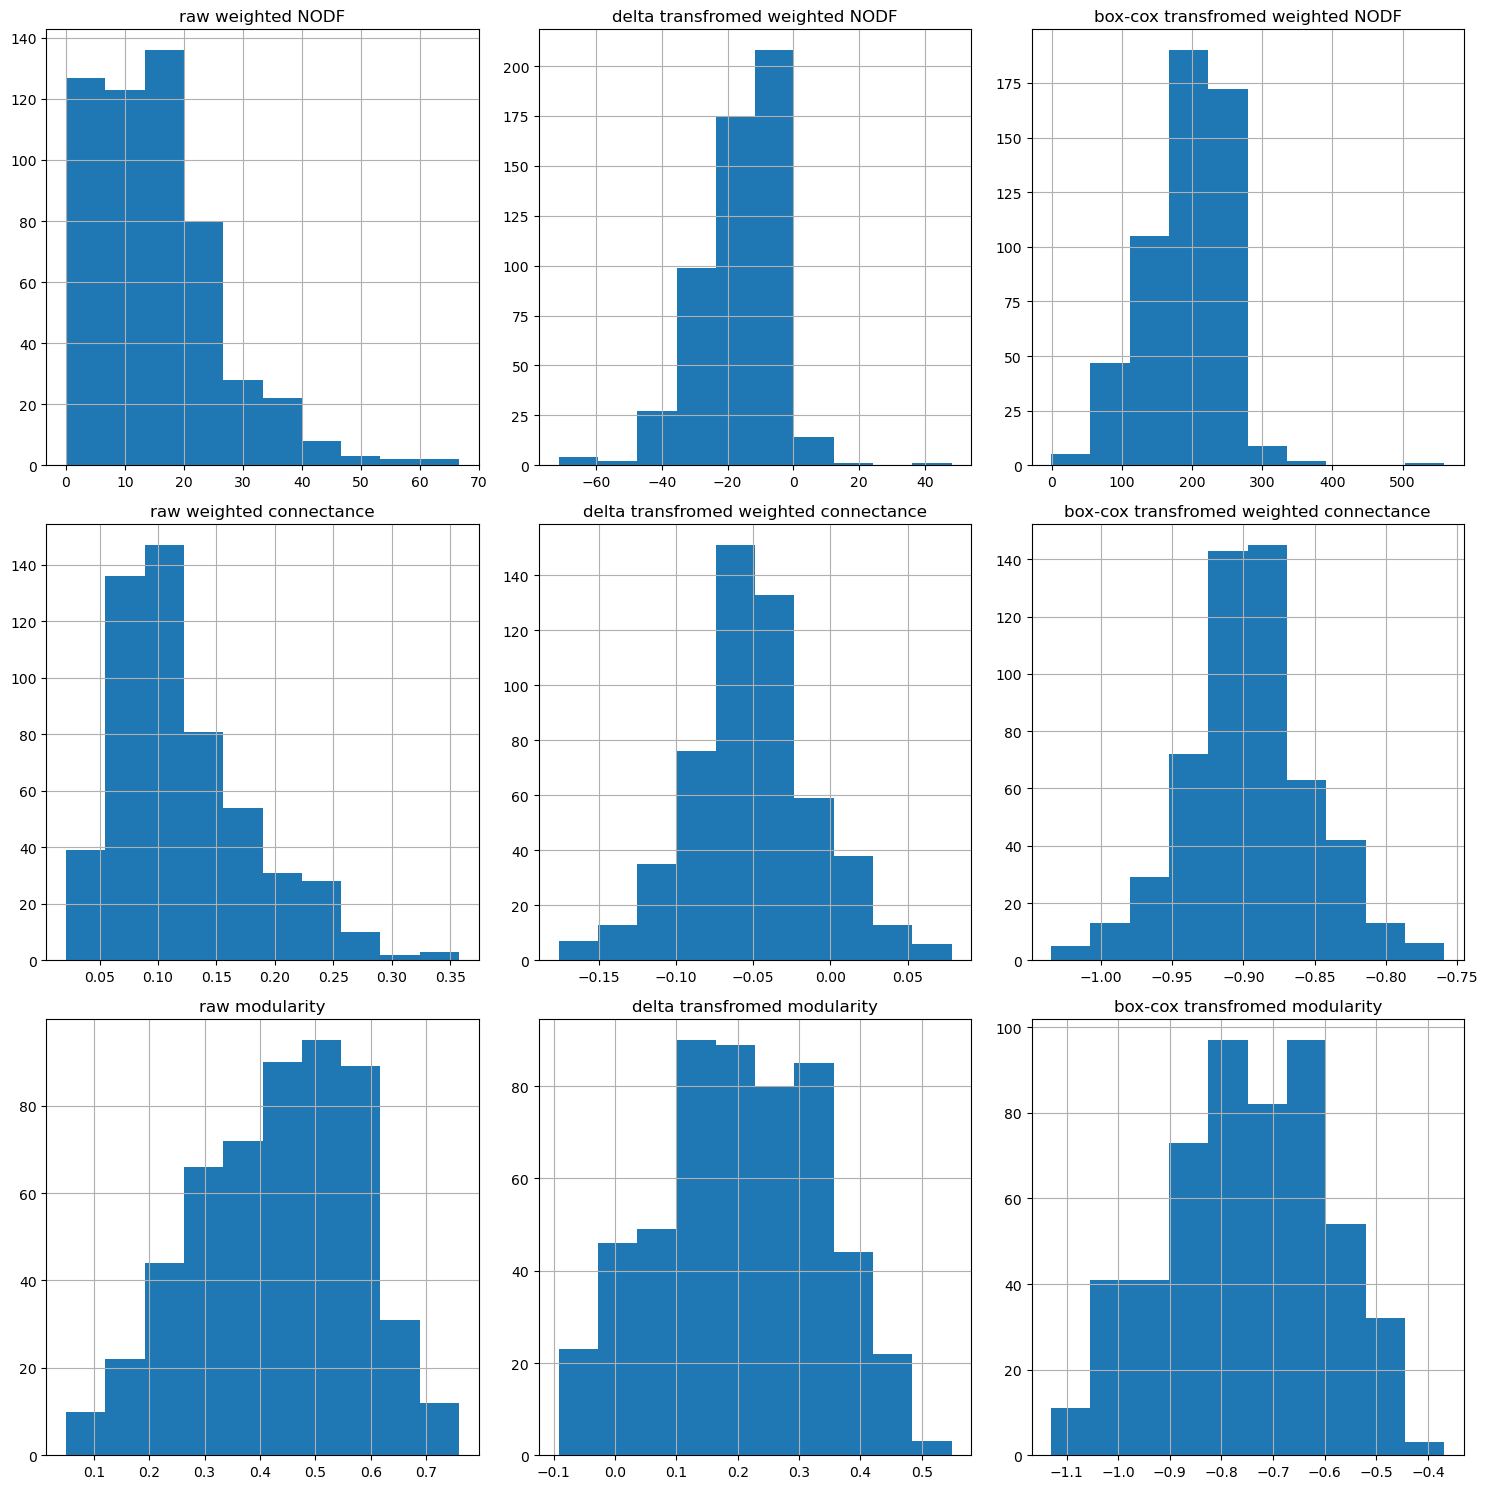

In [121]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=len(base_relevant_features), ncols=3, figsize=(3*5, len(base_relevant_features)*5))

for i in range(len(base_relevant_features)):
    f = base_relevant_features[i]
    ax0, ax1, ax2 = ax[i][0], ax[i][1], ax[i][2]
    clean_features[f"{f}"].hist(ax=ax0)
    ax0.set_title(f"raw {f}")
    clean_features[f"null_standardized_{f}"].hist(ax=ax1)
    ax1.set_title(f"delta transfromed {f}")
    clean_features[f"bc_transformed_{f}"].hist(ax=ax2)
    ax2.set_title(f"box-cox transfromed {f}")
    
fig.tight_layout()

# save data

In [122]:
relevant_features = base_relevant_features + [f"null_standardized_{f}" for f in base_relevant_features] #+ [f"bc_transformed_{f}" for f in base_relevant_features] 

In [123]:
clean_features = clean_features.drop_duplicates()
clean_features = clean_features.dropna(subset=relevant_features)
clean_features = clean_features.fillna(-1)
clean_features["network_size"] = clean_features["num_network_plants"] + clean_features["num_network_pollinators"]
print(f"# remaining records = {clean_features.shape[0]:,}")
clean_features.to_csv(processed_data_path)

# remaining records = 531


# plot data

In [124]:
clean_features = pd.read_csv(processed_data_path)

In [125]:
max_missing_threshold = 0.5
min_classified_threshold = 5
min_poly_threhold = 2
min_di_threshold = 2

clean_features = clean_features.loc[(clean_features.is_polyploid_missing_frac <= max_missing_threshold) &
                                    (clean_features.num_classified >= min_classified_threshold) &
                                    (clean_features.num_polyploids >= min_poly_threhold) &
                                    (clean_features.num_diploids >= min_di_threshold)] 

/groups/itay_mayrose/halabikeren/miniconda3/envs/ppn/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


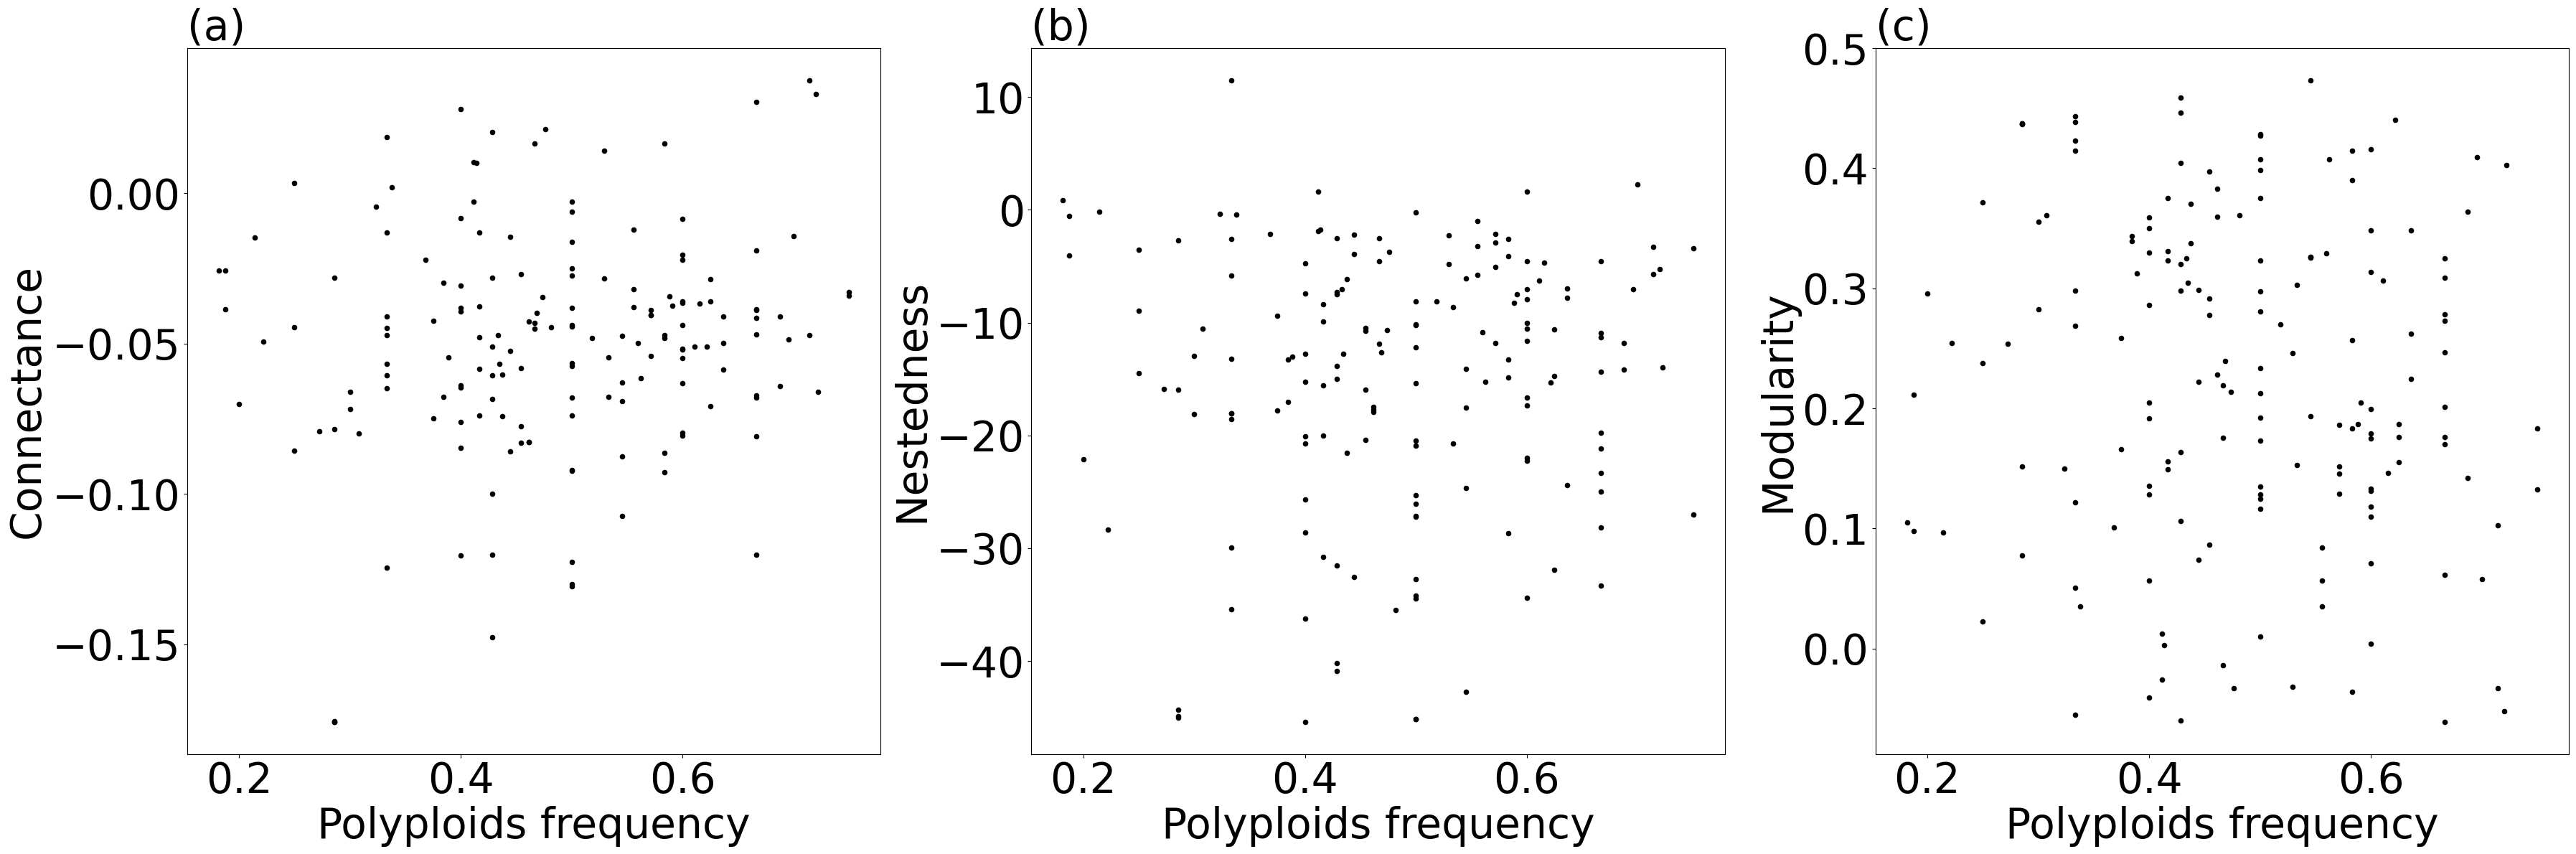

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["patch.force_edgecolor"] = False
fontsize = 42

plotting_features = clean_features#.loc[(clean_features.is_polyploid_missing_frac <= missing_data_threshold) & (clean_features.num_classified >= n_classified_threshold)]
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(3*12, 1*12))
plotting_features = clean_features.loc[clean_features.is_polyploid_missing_frac <= 0.3]

ax1 = ax[0]
ax1.set_title("(a)", loc="left", fontsize=fontsize)
plotting_features.plot.scatter(x="is_polyploid_poly_frac", y="null_standardized_weighted connectance", ax=ax1, color="black")
ax1.set_xlabel("Polyploids frequency", fontsize=fontsize)
ax1.set_ylabel("Connectance", fontsize=fontsize)
ax1.tick_params(axis='both', which='major', labelsize=fontsize)
ax1.tick_params(axis='both', which='minor', labelsize=fontsize)


ax2 = ax[1]
ax2.set_title("(b)", loc="left", fontsize=fontsize)
plotting_features.plot.scatter(x="is_polyploid_poly_frac", y="null_standardized_weighted NODF", ax=ax2, color="black")
ax2.set_xlabel("Polyploids frequency", fontsize=fontsize)
ax2.set_ylabel("Nestedness", fontsize=fontsize)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)
ax2.tick_params(axis='both', which='minor', labelsize=fontsize)


ax3 = ax[2]
ax3.set_title("(c)", loc="left", fontsize=fontsize)
plotting_features.plot.scatter(x="is_polyploid_poly_frac", y="null_standardized_modularity", ax=ax3, color="black")
ax3.set_xlabel("Polyploids frequency", fontsize=fontsize)
ax3.set_ylabel("Modularity", fontsize=fontsize)
ax3.tick_params(axis='both', which='major', labelsize=fontsize)
ax3.tick_params(axis='both', which='minor', labelsize=fontsize)

# ax4 = ax[1][1]
# ax4.set_title("(d)", loc="left", fontsize=fontsize)
# plotting_features.plot.scatter(x="is_polyploid_poly_frac", y="null_standardized_robustness.LL", ax=ax4, color="black")
# ax4.set_xlabel("Polyploids frequency", fontsize=fontsize)
# ax4.set_ylabel("Robustness", fontsize=fontsize)
# ax4.tick_params(axis='both', which='major', labelsize=fontsize)
# ax4.tick_params(axis='both', which='minor', labelsize=fontsize)


fig.tight_layout()
fig.savefig(f"../../../data/figures/fig3_{'binary' if not do_weighted else 'weighted'}.jpeg")

# create another file with networks for which the geographic location and bioclimatic info is available

In [127]:
networks_metadata = pd.read_csv(networks_metadata_path).rename(columns={'species_richness.y': 'species_richness'})
clean_features = pd.read_csv(processed_data_path)

In [128]:
bioclim_columns = ['Latitude', 'Longitude', 'EcoRegion','Annual Mean Temperature',
                   'Mean Diurnal Range (Mean of monthly (max temp - min temp))',
                   'Isothermality (BioClim_2/BioClim_7) (×100)',
                   'Temperature Seasonality (standard deviation ×100)',
                   'Max Temperature of Warmest Month', 'Min Temperature of Coldest Month',
                   'Temperature Annual Range (BioClim_5-BioClim_6)',
                   'Mean Temperature of Wettest Quarter',
                   'Mean Temperature of Driest Quarter',
                   'Mean Temperature of Warmest Quarter',
                   'Mean Temperature of Coldest Quarter', 'Annual Precipitation',
                   'Precipitation of Wettest Month', 'Precipitation of Driest Month',
                   'Precipitation Seasonality (Coefficient of Variation)',
                   'Precipitation of Wettest Quarter', 'Precipitation of Driest Quarter',
                   'Precipitation of Warmest Quarter', 'Precipitation of Coldest Quarter',
                   'species_richness']

In [129]:
clean_features["network_index"] = clean_features.network_id.apply(lambda x: int(x.split("_")[0]))

In [130]:
clean_features = clean_features.merge(networks_metadata[["network_index", "network_type"] + bioclim_columns], on=["network_type", "network_index"], how="left")

In [131]:
clean_features = clean_features[[c for c in clean_features.columns if not "Unnamed" in c]]
clean_features = clean_features.rename(columns={"species_richness.y": "species_richness"})

In [132]:
clean_features[bioclim_columns].notna().sum() / clean_features.shape[0]

Latitude                                                      0.357815
Longitude                                                     0.357815
EcoRegion                                                     0.310734
Annual Mean Temperature                                       0.310734
Mean Diurnal Range (Mean of monthly (max temp - min temp))    0.310734
Isothermality (BioClim_2/BioClim_7) (×100)                    0.310734
Temperature Seasonality (standard deviation ×100)             0.310734
Max Temperature of Warmest Month                              0.310734
Min Temperature of Coldest Month                              0.310734
Temperature Annual Range (BioClim_5-BioClim_6)                0.310734
Mean Temperature of Wettest Quarter                           0.310734
Mean Temperature of Driest Quarter                            0.310734
Mean Temperature of Warmest Quarter                           0.310734
Mean Temperature of Coldest Quarter                           0.310734
Annual

In [133]:
relevant_clean_features = clean_features.query("EcoRegion.notna()")
print(f"# networks with available geodata = {relevant_clean_features.shape[0]:,}")
relevant_clean_features.to_csv(processed_data_w_geo_path, index=False)

# networks with available geodata = 165


In [3]:
processed_data = pd.read_csv(processed_data_path)
networks_data = pd.read_csv("/groups/itay_mayrose/halabikeren/plant_pollinator_networks/data/networks/all/networks_metadata.csv")

In [9]:
max_missing_threshold = 0.5
min_classified_threshold = 5
min_poly_threhold = 2
min_di_threshold = 2

In [10]:
processed_data["included_in_analysis"] = processed_data.apply(lambda rec: rec.is_polyploid_missing_frac <= max_missing_threshold and rec.num_classified >= min_classified_threshold and rec.num_polyploids >= min_poly_threhold and rec.num_diploids >= min_di_threshold, axis=1)

In [14]:
processed_data["network_index"] = processed_data.network_id.apply(lambda x: int(x.split("_")[0]))

In [15]:
processed_data[["network_type", "network_index", "included_in_analysis"]].head()

,network_type,network_index,included_in_analysis
0,weighted,359,False
1,weighted,238,False
2,weighted,236,False
3,weighted,235,False
4,weighted,237,True


In [16]:
networks_data = networks_data.merge(processed_data[["network_type", "network_index", "included_in_analysis"]], on=["network_type", "network_index"], how="left")

In [19]:
networks_data.included_in_analysis = networks_data.included_in_analysis.fillna(False)

In [20]:
networks_data.query("included_in_analysis").shape[0]

246

In [28]:
relevant_networks_for_geo_collection = networks_data.query("included_in_analysis and Latitude.isna() and Longitude.isna()")

In [34]:
relevant_networks_for_geo_collection = relevant_networks_for_geo_collection[['network_index', 'path', 'source', 'is_legal', 'is_resolved', 'processed_path', 'is_parsed_legal', 'network_name', 'Latitude', 'Longitude', 'reference']]

In [35]:
refs = pd.read_csv("refs.csv")

In [38]:
relevant_networks_for_geo_collection = relevant_networks_for_geo_collection.merge(refs[["path", "doi"]], on="path", how="left")

In [40]:
relevant_networks_for_geo_collection.to_csv("network_data_for_geo_collection.csv")

In [46]:
relevant_networks_for_geo_collection.doi.dropna().unique()

array(['10.1111/oik.07303', '10.1371/journal.pbio.0060031',
       '10.1111/j.1365-2745.2005.01069.x'], dtype=object)